In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
def get_price_data(ticker, period="3y", interval="1d", close_only=True):
    yf_ticker = yf.Ticker(ticker)
    data = yf_ticker.history(period=period, interval=interval)
    if close_only:
        close_data = data[["Close"]].rename(columns={"Close": ticker})
        return close_data
    else:
        return data

def get_rf_rate(treasury_type="3m"):
    type_to_series = {
        "4wk": "DTB4WK",
        "3m": "DGS3MO",
        "6m": "DGS6MO",
        "1y": "DGS1",
        "3y": "DGS3",
        "5y": "DGS5",
        "7y": "DGS7",
        "10y": "DGS10",
    }
    series_id = type_to_series.get(treasury_type.lower())
    if not series_id:
        valid_options = ", ".join(f'"{option}"' for option in type_to_series.keys())
        raise ValueError(
            f"Treasury type '{treasury_type}' is not recognized. Valid options are: {valid_options}."
        )
    start = datetime.today() - timedelta(days=10)
    end = datetime.today()
    rate_data = pdr.get_data_fred(series_id, start, end)
    most_recent_rate = rate_data.iloc[-1, 0]
    most_recent_rate_pct = float(most_recent_rate) / 100  # type: ignore
    return most_recent_rate_pct

def get_market_return(market_ticker="^GSPC", period="10y"):
    end_date = pd.Timestamp.today()
    start_date = end_date - pd.DateOffset(years=int(period[:-1]))
    data = yf.download(market_ticker, start=start_date, end=end_date)
    data["Year"] = data.index.year
    annual_returns = []

    for year in range(start_date.year, end_date.year + 1):
        if year in data["Year"].values:
            yearly_data = data[data["Year"] == year]
            yearly_return = (
                yearly_data["Adj Close"][-1] / yearly_data["Adj Close"][0]
            ) - 1
            annual_returns.append(
                1 + yearly_return
            )

    # we use Geometric mean to account for compounding
    geom_mean_annual_return = np.prod(annual_returns) ** (1 / len(annual_returns)) - 1

    return float(geom_mean_annual_return)  # type: ignore

def calculate_capm(
    stock="AAPL",
    index="^GSPC",
    beta_period="3y",
    beta_interval="1wk",
    market_period="10y",
    treasury_type="3m",
):
    beta = calculate_beta(
        index=index,
        stock=stock,
        period=beta_period,
        interval=beta_interval,
        just_beta=True,
    )
    rf_rate = get_rf_rate(treasury_type=treasury_type)
    market_rate = get_market_return(market_ticker=index, period=market_period)
    equity_risk_premium = market_rate - rf_rate
    capm = rf_rate + (beta * equity_risk_premium)
    return capm


def get_russell1000_tickers():
    url = "https://en.wikipedia.org/wiki/Russell_1000_Index"
    tables = pd.read_html(url) 
    sp500_table = tables[2]  
    tickers = sp500_table["Ticker"].tolist()
    return tickers


def get_sp500_tickers():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    tables = pd.read_html(url)
    sp500_table = tables[0]
    tickers = sp500_table["Symbol"].tolist()
    return tickers

In [3]:
def calculate_beta(index, stock, period="3y", interval="1d", just_beta=False):
    index_data = get_price_data(index, period=period, interval=interval)
    stock_data = get_price_data(stock, period=period, interval=interval)

    stock_data["datum"] = stock_data.index
    stock_data["datum_short"] = stock_data["datum"].dt.strftime('%Y.%m.%d')
    
    stock_data.set_index("datum_short")
    
    index_data["datum"] = index_data.index
    index_data["datum_short"] = index_data["datum"].dt.strftime('%Y.%m.%d')
    
    index_data.set_index("datum_short")
    
    data = pd.merge(index_data, stock_data, left_on="datum_short", right_on="datum_short")
    
    data[f"{index}_return"] = data[index].pct_change()
    data[f"{stock}_return"] = data[stock].pct_change()

    data.dropna(inplace=True)
    
    X = data[f"{index}_return"].values.reshape(-1, 1)
    y = data[f"{stock}_return"].values

    model = LinearRegression().fit(X, y)

    beta = model.coef_[0]

    if just_beta:
        return beta
    else:
        return beta, model

          ^GSPC                   datum_x datum_short      ASM.AS  \
1   4478.029785 2023-07-31 00:00:00-04:00  2023.07.31  445.568085   
2   4464.049805 2023-08-07 00:00:00-04:00  2023.08.07  433.571472   
3   4369.709961 2023-08-14 00:00:00-04:00  2023.08.14  423.167725   
4   4405.709961 2023-08-21 00:00:00-04:00  2023.08.21  421.077057   
5   4515.770020 2023-08-28 00:00:00-04:00  2023.08.28  441.137817   
6   4457.490234 2023-09-04 00:00:00-04:00  2023.09.04  430.634521   
7   4450.319824 2023-09-11 00:00:00-04:00  2023.09.11  386.281799   
8   4320.060059 2023-09-18 00:00:00-04:00  2023.09.18  383.792877   
9   4288.049805 2023-09-25 00:00:00-04:00  2023.09.25  395.739746   
10  4308.500000 2023-10-02 00:00:00-04:00  2023.10.02  397.730896   
11  4327.779785 2023-10-09 00:00:00-04:00  2023.10.09  383.743103   
12  4224.160156 2023-10-16 00:00:00-04:00  2023.10.16  358.405792   
13  4117.370117 2023-10-23 00:00:00-04:00  2023.10.23  390.064972   
14  4358.339844 2023-10-30 00:00:0

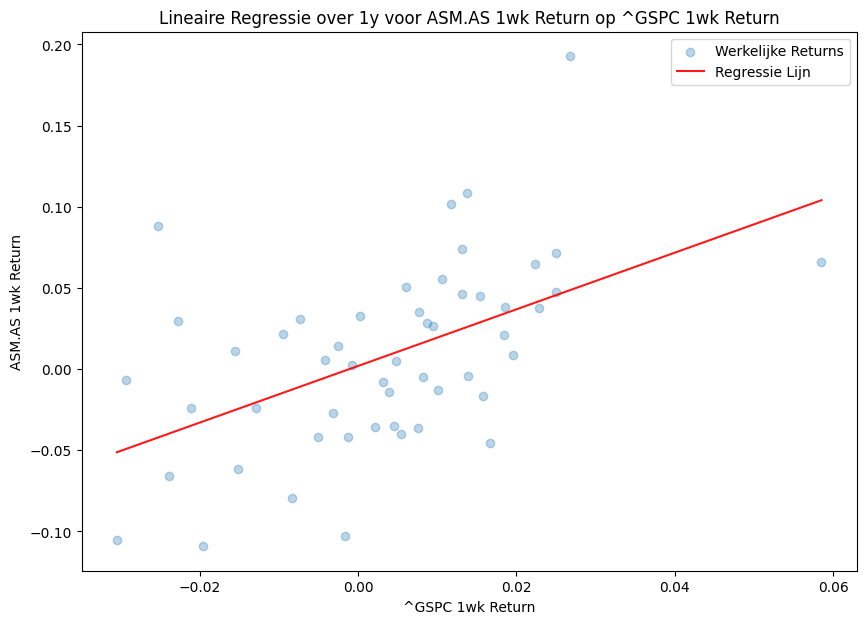

In [4]:
stock="ASM.AS"
index="^GSPC"

interval="1wk"
period="1y"

index_data = get_price_data(index, period="1y", interval="1wk")
stock_data = get_price_data(stock, period="1y", interval="1wk")

stock_data["datum"] = stock_data.index
stock_data["datum_short"] = stock_data["datum"].dt.strftime('%Y.%m.%d')

index_data["datum"] = index_data.index
index_data["datum_short"] = index_data["datum"].dt.strftime('%Y.%m.%d')

data = pd.merge(index_data, stock_data, left_on="datum_short", right_on="datum_short")

data[f"{index}_return"] = data[index].pct_change()
data[f"{stock}_return"] = data[stock].pct_change()

data.dropna(inplace=True)

print(data)

X = data[f"{index}_return"].values.reshape(-1, 1)
y = data[f"{stock}_return"].values

model = LinearRegression().fit(X, y)

X_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
Y_line = model.predict(X_line)

plt.figure(figsize=(10, 7))
plt.scatter(X, y, alpha=0.3, label="Werkelijke Returns")
plt.plot(X_line, Y_line, "r", alpha=0.9, label="Regressie Lijn")
plt.xlabel(f"{index} {interval} Return")
plt.ylabel(f"{stock} {interval} Return")
plt.title(
    f"Lineaire Regressie over {period} voor {stock} {interval} Return op {index} {interval} Return"
)

plt.legend()
plt.show()

In [5]:
excelStocks = 'data\\Data2.xlsx'
df = pd.read_excel(excelStocks, sheet_name='Ticker')
dfTicker = pd.DataFrame(df, columns=['Ticker', 'Naam'])

listFields=['Ticker'] + ['Naam'] + ['Beta'] 
dfResult = pd.DataFrame(
     columns=listFields)

symbolnr = 0
for index, row in dfTicker.iterrows():
    symbol = row['Ticker']
    companyName = row['Naam']
    print(symbol)
    
    index = "^GSPC"
    # ^RUA
    stock = symbol
    period = "1y"
    interval = "1wk"
    beta, model = calculate_beta(index, stock, period, interval)
    print(f"{stock} beta compared to {index} is: {beta.round(4)}")
    dfResult.loc[symbolnr] = [symbol, companyName, beta]
    symbolnr += 1

dfResult.to_excel("data\\FinancialData.xlsx")

MELE.BR
MELE.BR beta compared to ^GSPC is: 1.574
PEUG.PA
PEUG.PA beta compared to ^GSPC is: 0.8104
FGR.PA
FGR.PA beta compared to ^GSPC is: 0.5963
RACE.MI
RACE.MI beta compared to ^GSPC is: 1.0183
ASML.AS
ASML.AS beta compared to ^GSPC is: 1.7399
MC.PA
MC.PA beta compared to ^GSPC is: 0.8176
EKOP.BR
EKOP.BR beta compared to ^GSPC is: 0.2381
UMI.BR
UMI.BR beta compared to ^GSPC is: 0.3867
AMG.AS
AMG.AS beta compared to ^GSPC is: 0.5885
SOF.BR
SOF.BR beta compared to ^GSPC is: 1.1139
DECB.BR
DECB.BR beta compared to ^GSPC is: 0.1613
MA
MA beta compared to ^GSPC is: 0.9095
MSFT
MSFT beta compared to ^GSPC is: 1.0894
GOOG
GOOG beta compared to ^GSPC is: 1.349
NEE
NEE beta compared to ^GSPC is: 0.4231
FTNT
FTNT beta compared to ^GSPC is: 0.9953
ISRG
ISRG beta compared to ^GSPC is: 1.5161
INTC
INTC beta compared to ^GSPC is: 1.5636
ADBE
ADBE beta compared to ^GSPC is: 1.534
BA.L
BA.L beta compared to ^GSPC is: 0.0887
FNV.TO
FNV.TO beta compared to ^GSPC is: -0.1584
CSU.TO
CSU.TO beta compare

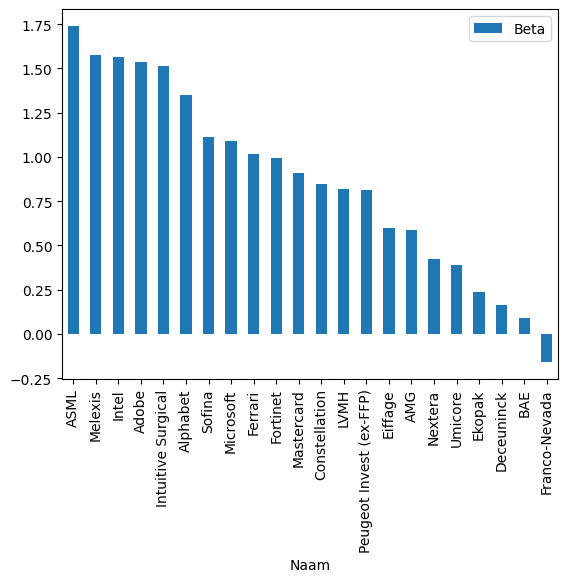

In [6]:
dfResult = dfResult.sort_values("Beta", ascending=False)
ax = dfResult.plot.bar(x='Naam', y='Beta', rot=90)